In [1]:
import json, os, sys

from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    
import utils
import result_helper


sns.set(style="whitegrid")

In [2]:
skadi_job_paths = list(Path("../data/experiments-skadi/").glob("**/job-info.json"))
odin_job_paths = list(Path("../data/experiments-odin/").glob("**/job-info.json"))

job_paths = skadi_job_paths + odin_job_paths

df_data = result_helper.get_result_summary(job_paths)

cols_irrelavant = [
    "started_at", "completed_at", "precision_score", "recall_score", "f1_score", "random_seed",
    'experiment_type', 'experiment_name', 'component_size', 'variance', 'label_noise_proba',
    'allow_self_loops', 'distance_metric', 'job_path', 'duration_secs'
]
cols_relevant = list(set(df_data.columns) - set(cols_irrelavant))

## Impact of separation on a single-step random walk

Experiment parameters:
- $k = d$ i.e., number of components is the same as the number of dimensions 
- $\beta = k^{1/4}$
- Number of random walk steps: 1
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added
- No self-loops


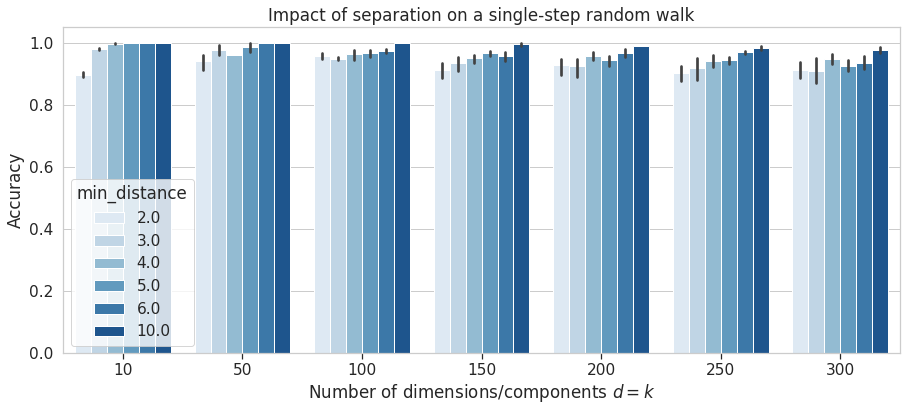

In [3]:
filter_dist_1 = df_data.experiment_name == "dim_dist_01"
filter_dist_2 = df_data.experiment_name == "dim_dist_02"
df_data_filtered = df_data[filter_dist_1 | filter_dist_2].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score",hue="min_distance",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact of separation on a single-step random walk");
    # ax.set_ylim([0, 1])

## Impact of short random walks

Experiment parameters:
- $k = d$ i.e., number of components is the same as the number of dimensions 
- $\beta = k^{1/4}$
- Separation: 2 or 3
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added
- No self-loops


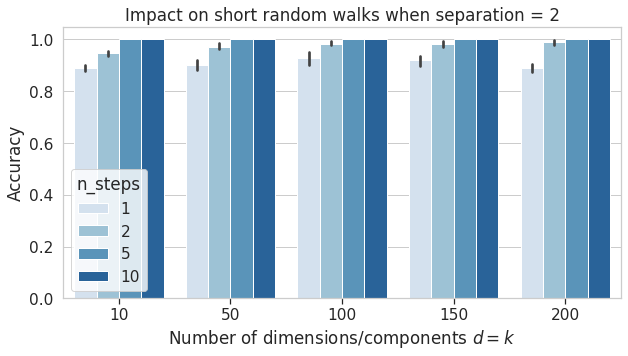

In [4]:
filter_steps_01 = df_data.experiment_name == "dim_steps_01"
df_data_filtered = df_data[filter_steps_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact on short random walks when separation = 2");
    # ax.set_ylim([0, 1])

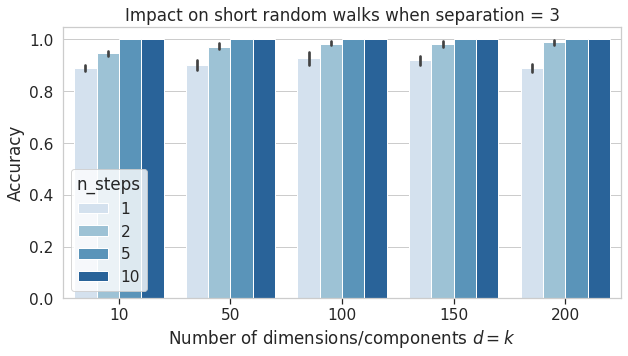

In [5]:
filter_steps_02 = df_data.experiment_name == "dim_steps_02"
df_data_filtered = df_data[filter_steps_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact on short random walks when separation = 3");
    # ax.set_ylim([0, 1])

## Impact of long walks: $\ge$ 10 steps

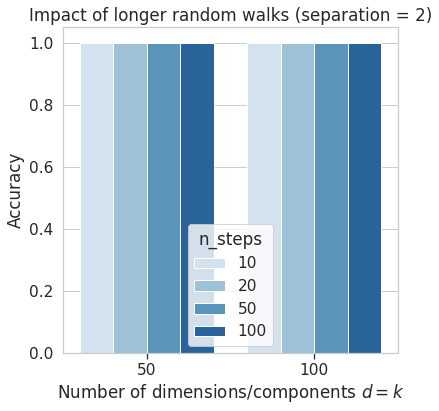

In [6]:
filter_steps_03 = df_data.experiment_name == "dim_steps_03"
filter_steps_04 = df_data.experiment_name == "dim_steps_04"
df_data_filtered = df_data[filter_steps_03 | filter_steps_04].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact of longer random walks (separation = 2)");
    # ax.set_ylim([0, 1])

## Impact of no bias ($\beta = 1$) and long walks

Experiment parameters:
- $k = d$ i.e., number of components is the same as the number of dimensions 
- $\beta = 1$
- Separation: 2
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added
- No self-loops


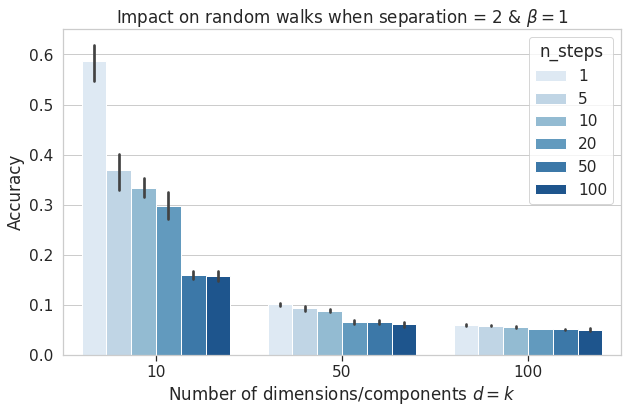

In [7]:
filter_dim_steps_no_bias_01 = df_data.experiment_name == "dim_steps_no_bias_01"
df_data_filtered = df_data[filter_dim_steps_no_bias_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score", hue="n_steps",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact on random walks when separation = 2 & $\\beta = 1$");
    # ax.set_ylim([0, 1])

## Impact of varying bias factor

Experiment parameters:
- $k = d$ i.e., number of components is the same as the number of dimensions 
- $\beta$: $k^{1/512}$, $k^{1/256}$, $k^{1/128}$, $k^{1/64}$, $k^{1/32}$, $k^{1/16}$, $k^{1/8}$, $k^{1/4}$
- Number of steps: 2
- Separation: 2
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added
- No self-loops


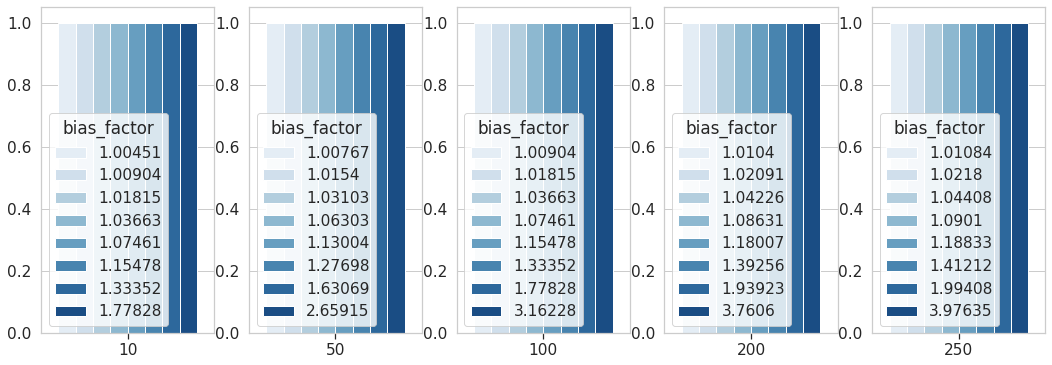

In [8]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig, axes = plt.subplots(ncols=5, figsize=(18, 6))
    for i, n_dim in enumerate([10, 50, 100, 200, 250]):
        filter_dim_bias_01 = df_data.experiment_name == "dim_bias_01"
        filter_dim_bias_02 = df_data.experiment_name == "dim_bias_02"
        filter_dim_bias_03 = df_data.experiment_name == "dim_bias_03"
        filter_dim = df_data.n_dim == n_dim
        df_data_filtered = df_data[(filter_dim_bias_01 | filter_dim_bias_02 | filter_dim_bias_03) & filter_dim].copy()
        df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])
        df_data_filtered["bias_factor"] = df_data_filtered["bias_factor"].round(5)
        
        sns.barplot(
            x="n_dim",y="accuracy_score", hue="bias_factor",
            data=df_data_filtered,palette="Blues", ax=axes[i]
        )
        #ax.legend(title='Bias factor: $\\beta$', loc='upper left', labels=['1/4', '1/8', '1/16', '1/32'])
        axes[i].yaxis.grid(True)
        axes[i].yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
        axes[i].tick_params(which="both", bottom=True)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        axes[i].set_title(f"");

        # ax.set_ylim([0, 1])

## Impact of small separation, 1 & 1/2

Experiment parameters:
- $k = d$ i.e., number of components is the same as the number of dimensions 
- $\beta = k^{1/4}$
- Number of steps: 10
- Separation: 1/2 or 1
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added
- No self-loops


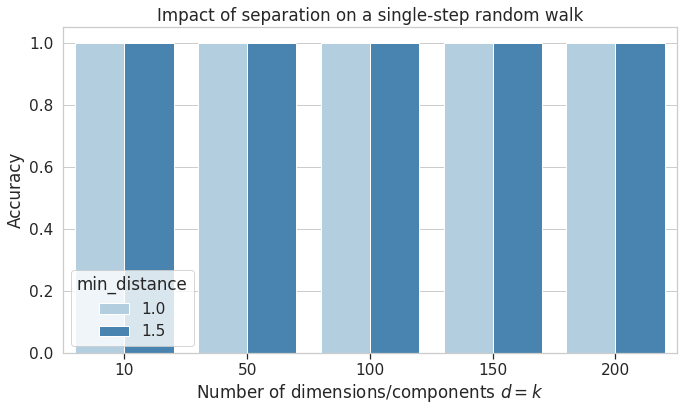

In [9]:
filter_small_dist_01 = df_data.experiment_name == "small_dist_01"
df_data_filtered = df_data[filter_small_dist_01].copy()
df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(11, 6))
    sns.barplot(
        x="n_dim",y="accuracy_score",hue="min_distance",
        data=df_data_filtered,palette="Blues", ax=ax
    )
    ax.yaxis.grid(True)
    ax.yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
    ax.tick_params(which="both", bottom=True)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Number of dimensions/components $d=k$")
    ax.set_title(f"Impact of separation on a single-step random walk");
    # ax.set_ylim([0, 1])

## Impact of separation $< 1$

Experiment parameters:
- $k = d$ i.e., number of components is the same as the number of dimensions 
- $\beta = k^{1/4}$
- Number of steps: 10
- Separation: $\frac{1}{k^{1/m}}$ where $m = \{ 64, 16, 8, 4 \}$ 
- Number of points in each Gaussian component: 50
- Variance in each component: 1
- No label noise added
- No self-loops


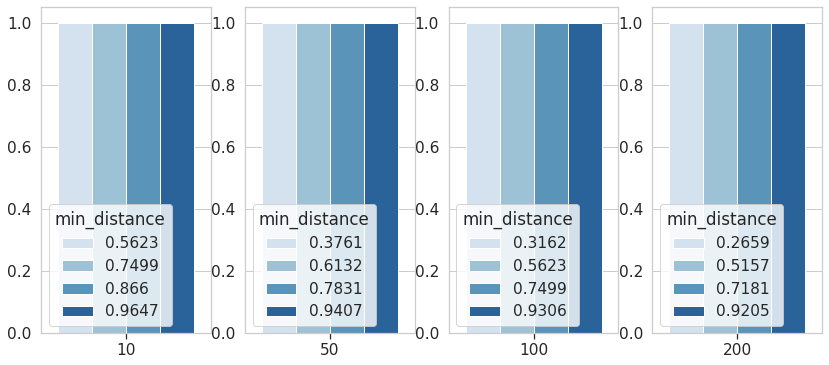

In [10]:
with sns.plotting_context("notebook", font_scale=1.4):
    fig, axes = plt.subplots(ncols=4, figsize=(14, 6))
    for i, n_dim in enumerate([10, 50, 100, 200]):
        filter_dist_below_one_01 = df_data.experiment_name == "dist_below_one_01"
        filter_dim = df_data.n_dim == n_dim
        df_data_filtered = df_data[filter_dist_below_one_01 & filter_dim].copy()
        df_data_filtered = df_data_filtered.sort_values(["min_distance", "n_dim", "bias_factor", "n_steps"])
        df_data_filtered["min_distance"] = df_data_filtered["min_distance"].round(4)
        
        sns.barplot(
            x="n_dim",y="accuracy_score",hue="min_distance",
            data=df_data_filtered,palette="Blues", ax=axes[i]
        )
        axes[i].yaxis.grid(True)
        axes[i].yaxis.set_minor_locator(ticker.LinearLocator(numticks=10))
        axes[i].tick_params(which="both", bottom=True)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        #axes[i].set_title(f"Impact of separation < 1");
        # ax.set_ylim([0, 1])